# Image classifier using tensor processing units (TPUs):

## Author: Dr. Rahul Remanan 
### (CEO and Chief Imagination Officer, [Moad Computer](https://www.moad.computer))

### Demo data: [Kaggle Cats Vs. Dogs Redux](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

### [Run this notebook in Google CoLab]()

## Download data into CoLab instance:

In [1]:
! pip3 install kaggle

In [2]:
from google.colab import files

uploaded = files.upload() 

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle/
! cp ./kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [4]:
! ls /root/.kaggle/

kaggle.json


In [5]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 268M/271M [00:02<00:00, 107MB/s]
100% 271M/271M [00:02<00:00, 117MB/s]
 98% 532M/544M [00:05<00:00, 84.2MB/s]
100% 544M/544M [00:06<00:00, 93.8MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 92.5MB/s]


In [6]:
! rm ./kaggle.json
! rm /root/.kaggle/kaggle.json
! rm -r ./datalab
! rm -r ./data
! rm -r ./sample_data/

rm: cannot remove './datalab': No such file or directory
rm: cannot remove './sample_data/': No such file or directory


In [0]:
! mkdir ./data
! mkdir ./data/train
! mkdir ./data/train/cats
! mkdir ./data/train/dogs
! mkdir ./data/preview
! mkdir ./data/validation
! mkdir ./data/validation/cats/
! mkdir ./data/validation/dogs/

In [8]:
!ls

data  model  sample_submission.csv  test.zip  train.zip


In [0]:
! mv ./*.zip ./data/

In [0]:
! unzip -q ./data/train.zip -d ./data/train/

## Label training data:

In [0]:
! mv ./data/train/train/cat.* ./data/train/cats/
! mv ./data/train/train/dog.* ./data/train/dogs/

In [0]:
! ls ./data/train/train/

In [0]:
! rm -r ./data/train/train

In [14]:
! ls ./data/train/dogs/ -1 | wc -l

12500


In [15]:
! ls ./data/train/cats/ -1 | wc -l

12500


## Create train-validation split:

In [0]:
! cd ./data/train/cats/ ; shuf -n 500 -e * | xargs -i mv {} ../../../data/validation/cats/

In [0]:
! cd ./data/train/dogs/ ; shuf -n 500 -e * | xargs -i mv {} ../../../data/validation/dogs/

In [18]:
! ls ./data/train/cats/ -1 | wc -l

12000


In [19]:
! ls ./data/train/dogs/ -1 | wc -l

12000


In [20]:
! ls ./data/validation/cats/ -1 | wc -l

500


In [21]:
! ls ./data/validation/dogs/ -1 | wc -l

500


In [22]:
! rm -r ./data/validation/cats/model
! rm -r ./data/validation/cats/datalab

rm: cannot remove './data/validation/cats/model': No such file or directory
rm: cannot remove './data/validation/cats/datalab': No such file or directory


In [23]:
! mkdir ./model/

mkdir: cannot create directory ‘./model/’: File exists


## Part 01 - [Using Keras pre-processing:](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

### Why perform image augmentation?

In order to make the most out of our few training image data, the process of "augmentation" of these images via a number of random transformations is helpful. This process feed the data to the neural network model, so that it would never see twice the exact same picture. The key advantage of implementation such an augmentation strategy is to help prevent overfitting and better generalization by the trained model.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

* configure random transformations and normalization operations to be done on your image data during training
* instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

### Example implementation of image augmentation in Keras:

In [24]:
try:
    import warnings
    warnings.filterwarnings('ignore')
    from keras.preprocessing.image import ImageDataGenerator
except:
    print ("Please install Keras (cmd: $sudo pip3 install keras) to run this notebook ...")

Using TensorFlow backend.


In [0]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

### Image Augmentation in Keras -- Quick start:

For more information, see the [documentation](https://keras.io/preprocessing/image/).

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
* shear_range is for randomly applying [shearing transformations](https://en.wikipedia.org/wiki/Shear_mapping)
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [28]:
import os, random
random_image = random.choice(os.listdir('./data/train/cats/'))

img = load_img(os.path.join('./data/train/cats/' + str(random_image)))
print ('Loaded image for preview : ' + str(random_image))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./data/preview/', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break

Loaded image for preview : cat.8608.jpg


### Keras pre-processing overview:

* The load_img uses Pillow, a complete fork of PIL. This creates a PIL image.
* The img_to_array creates a Numpy array with shape (3, 150, 150).
* The reshape command creates a Numpy array with shape (1, 3, 150, 150).
* The .flow() command below generates batches of randomly transformed images and saves the results to the `../data/cats_dogs/preview/` directory
* The break function prevents the loop from iterating indefinitely.

In [0]:
import os
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt
from IPython.display import Image as PyImage

In [0]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpl_image.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [0]:
def stack_plot(stack_size, folder):
    rows, cols = stack_size, stack_size
    fig,ax = plt.subplots(rows,cols,figsize=[24,24])
    i = 0
    try:
        for filename in os.listdir(folder):
            img = mpl_image.imread(os.path.join(folder, filename))
            ax[int(i/rows),int(i % rows)].imshow(img)
            ax[int(i/rows),int(i % rows)].axis('off')
            i += 1
    except:
        print ("Failed to add an image to the stacked plot ...")
    plt.show()

### Plotting augmented images:

* Using matplotlib library.
* The load_images function return a Numpy array of all the images in the folder specified in the function.
* The stack_plot generates a stack of images contained inside a specific folder of size: stack_size*stack_size

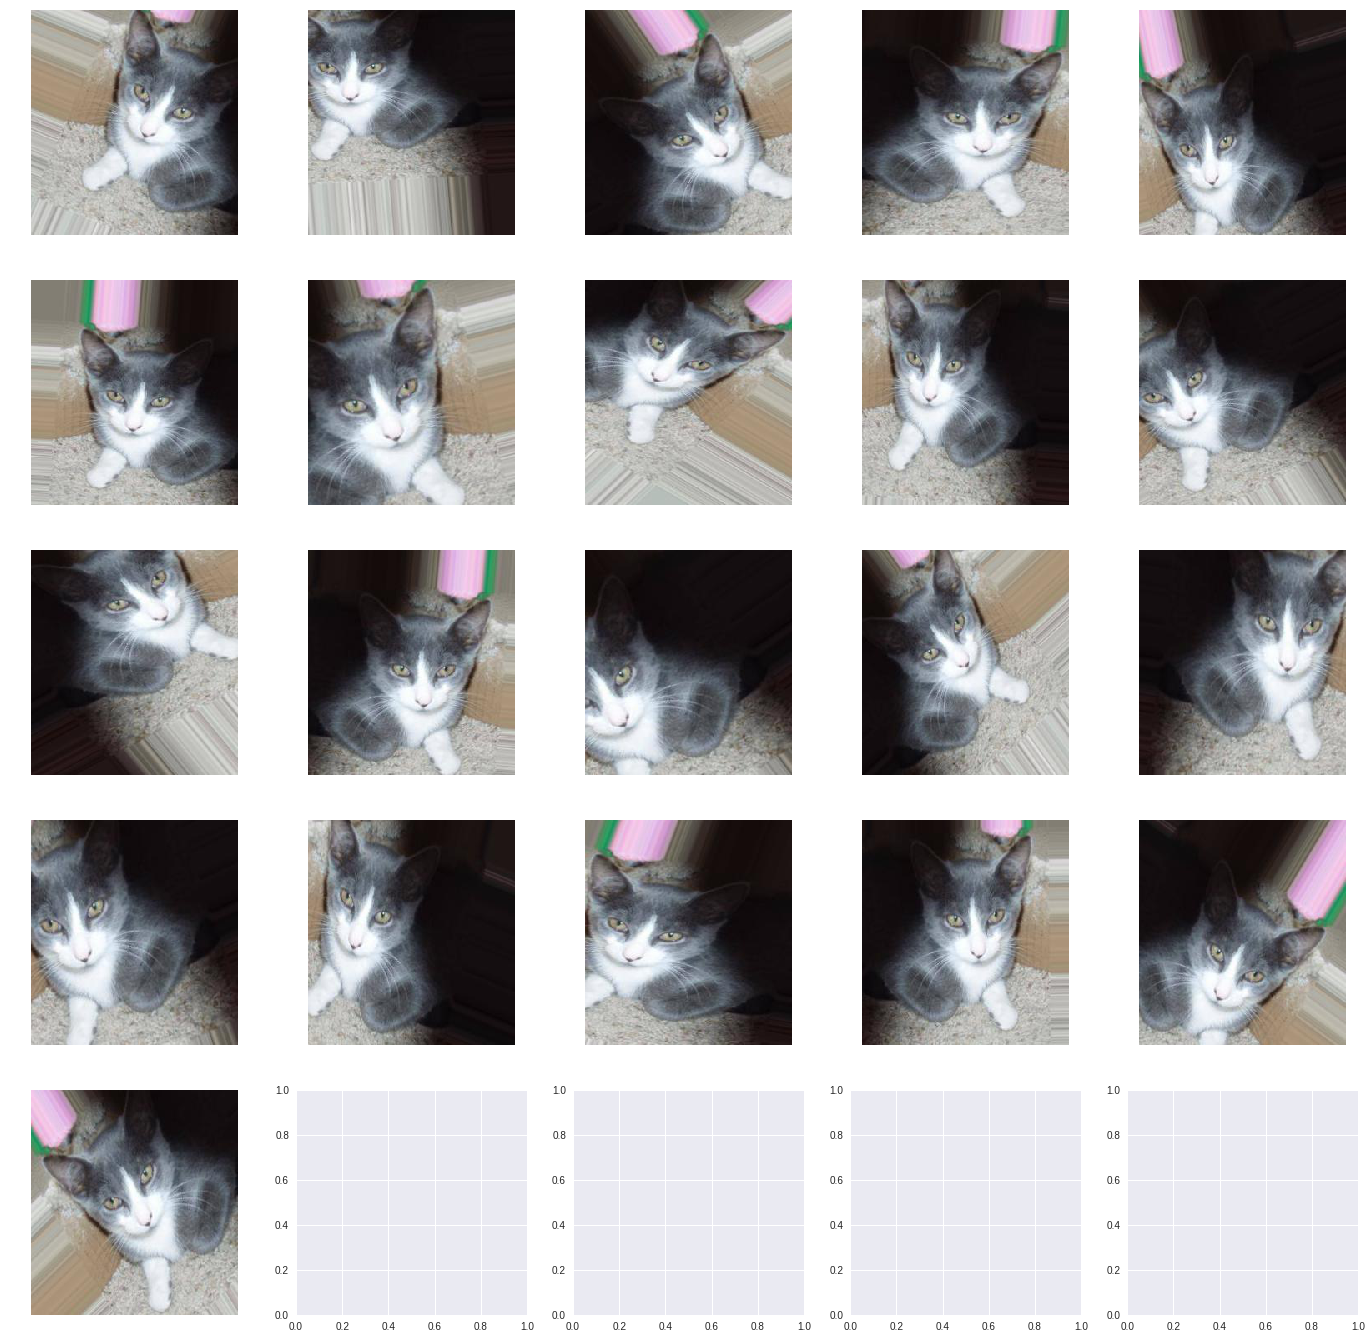

In [32]:
stack_plot(5, './data/preview/')

## Part 02 - Implementing a convolutional neural network that uses image augmentation:

### Importing dependent libraries:

In [0]:
use_tpu=True

In [0]:
import os
if use_tpu:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

In [0]:
import tensorflow as tf

* Importing preprocessing.image and models functions from Keras
* Importing layers function
* Importing keras backend

### Initialize some variables:

In [0]:
img_width, img_height = 150, 150

train_data_dir = './data/train/'
validation_data_dir = './data/validation/'

nb_train_samples = 24000
nb_validation_samples = 1000

epochs = 5
batch_size = 16

In [0]:
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

* Using img_width, img_height variables for specifying the dimensions of images to be consumed by the neural network
* Initilaizing variables for location pointers to training data, validation data, train data sample size, validation data sample size, number of training epochs, number of images to be processed in each batch
* Specifying a function to adjust input shape of the tensor if the image RGB data format is channels first or channels last

### Build and compile a neural network:

* Building a neural network model using the Sequential format in Keras
* Compile the model using binary cross entropy as the loss function, RMSProp as the optimizer and accuracy as the evaluation metrics

In [38]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Configuring data generators to process and feed the data to the neural network:

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

* The image augmentation configuration for training

In [0]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

* Image augmentation configuration to be used for testing
* This generator uses only rescaling

### Creating train and validation generators:

In [42]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

Found 24000 images belonging to 2 classes.


In [43]:
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


### Download pre-trained weights file:

In [44]:
! wget https://github.com/rahulremanan/HIMA/raw/master/examples/Notebooks/01_Image_augmentation/weights/first_try.h5

--2019-03-05 05:58:05--  https://github.com/rahulremanan/HIMA/raw/master/examples/Notebooks/01_Image_augmentation/weights/first_try.h5
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/HIMA/master/examples/Notebooks/01_Image_augmentation/weights/first_try.h5 [following]
--2019-03-05 05:58:06--  https://media.githubusercontent.com/media/rahulremanan/HIMA/master/examples/Notebooks/01_Image_augmentation/weights/first_try.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4879872 (4.7M) [application/octet-stream]
Saving to: ‘first_try.h5’

first_try.h5      

In [0]:
! mv ./first_try.h5 ./model/

In [46]:
#tf.keras.backend.clear_session()
if use_tpu:
  model = tf.contrib.tpu.keras_to_tpu_model(model,
                                            strategy=tf.contrib.tpu.TPUDistributionStrategy(
                                            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.34.86.114:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13126367907886618352)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4041386045717868625)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17714324021183557735)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

###[ Loading saved model weights file using Keras](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model):

In [0]:
model_path = './model/first_try.h5'
lr = 1e-4

In [48]:
if os.path.exists(model_path) and use_tpu:
  model.load_weights(model_path)
  print ('Loaded saved weights file ...')
elif os.path.exists(model_path):
  model.load_weights(model_path)
  print ('Loaded saved weights file ...')
else:
  print ('Failed to load model weights ...')

Loaded saved weights file ...


### Creating a model fit generator function for training the neural network:

In [49]:
model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    callbacks = [tf.contrib.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                          min_delta=0, 
                                                                          patience=10, 
                                                                          verbose=0, 
                                                                          mode='min'),
                                 tf.contrib.keras.callbacks.ModelCheckpoint(model_path,
                                                                            monitor='val_loss', 
                                                                            save_best_only=True, 
                                                                            mode='min', 
                                                                            verbose=0),
                                 tf.contrib.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                                              patience=2,
                                                                              mode = 'max',
                                                                              min_delta=1e-4, 
                                                                              cooldown=1,
                                                                              verbose=1, 
                                                                              factor=0.5, 
                                                                              min_lr=lr*1e-4)])
model.save_weights(model_path, 
                   overwrite=True)

Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(2, 150, 150, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(2, 1), dtype=tf.float32, name='activation_4_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7f01920e2e80> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.895431280136108 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU rho: 0.8999999761581421 {0.9}
INFO:

### Saving model weights at the end of the training session:

In [50]:
model.save_weights(model_path)

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0005000000237487257
INFO:tensorflow:TPU -> CPU rho: 0.8999999761581421
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07


In [51]:
! ls ./model/

first_try.h5


In [0]:
from google.colab import files
files.download(model_path)